In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])


In [3]:
from torchvision import datasets, transforms
train_dataset = datasets.ImageFolder('/kaggle/input/potholehumpvgg/customdataset/train', transform=transform)
test_dataset = datasets.ImageFolder('/kaggle/input/vggtest/vggtest', transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)



In [4]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([32, 3, 224, 224])
Image label dimensions: torch.Size([32])
Class labels of 10 examples: tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 1])


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [6]:
BATCH_SIZE = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
num_classes = 2
num_epochs = 30
batch_size = 32
learning_rate = 0.01
model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [8]:
import gc
total_step = len(train_loader)
valid_loader = test_loader
num_epochs = 100
best_accuracy = 0.0
best_model_weights = None

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        accuracy = 100 * correct/total
        print('Accuracy of the network on the {} validation images: {:.2f} %'.format(len(valid_loader.dataset), accuracy))
        
        # Check if current model is the best, if so, save its weights
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_weights = model.state_dict()
            torch.save(best_model_weights, 'best_model.pth')

# After training, load the best weights
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)
    print("Best model loaded.")
else:
    print("No best model found.")


Epoch [1/100], Loss: 0.0377
Accuracy of the network on the 163 validation images: 57.06 %
Epoch [2/100], Loss: 0.0046
Accuracy of the network on the 163 validation images: 57.67 %
Epoch [3/100], Loss: 2.6230
Accuracy of the network on the 163 validation images: 62.58 %
Epoch [4/100], Loss: 0.1877
Accuracy of the network on the 163 validation images: 66.26 %
Epoch [5/100], Loss: 0.0019
Accuracy of the network on the 163 validation images: 65.03 %
Epoch [6/100], Loss: 0.0524
Accuracy of the network on the 163 validation images: 63.19 %
Epoch [7/100], Loss: 2.6613
Accuracy of the network on the 163 validation images: 61.35 %
Epoch [8/100], Loss: 0.0032
Accuracy of the network on the 163 validation images: 69.33 %
Epoch [9/100], Loss: 0.0047
Accuracy of the network on the 163 validation images: 75.46 %
Epoch [10/100], Loss: 1.9761
Accuracy of the network on the 163 validation images: 68.10 %
Epoch [11/100], Loss: 1.5299
Accuracy of the network on the 163 validation images: 68.10 %
Epoch [1

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [10]:
classes = ['hump', 'pothole']

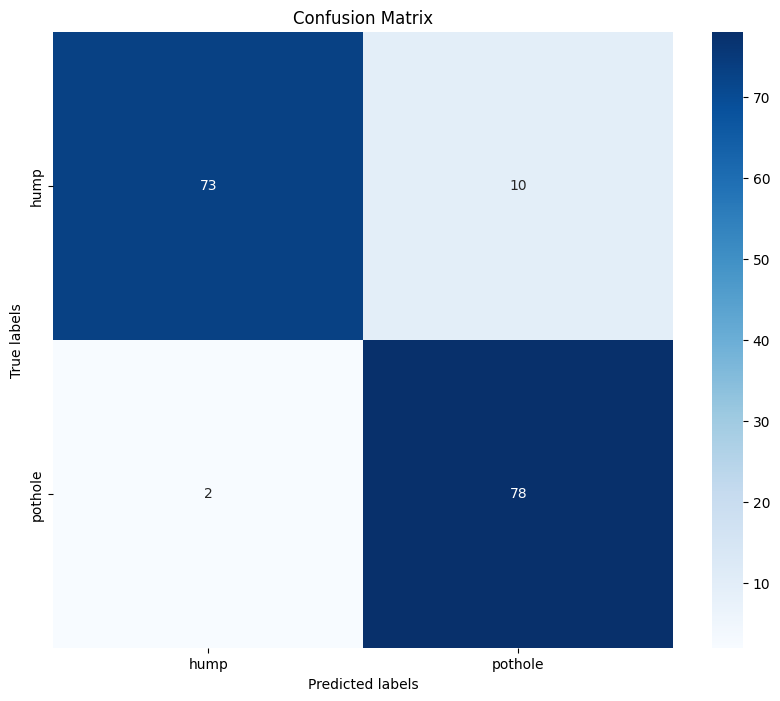

In [11]:
model.eval()  # set the model to evaluation mode

# Prepare test data
# Assuming test_data and test_targets are your test dataset and its corresponding targets

# Perform inference
predictions = []
true_labels = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to('cuda'), targets.to('cuda') 
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())
        true_labels.extend(targets.tolist())

# Convert predictions and true labels to numpy arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [12]:
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        83
           1       0.89      0.97      0.93        80

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.93       163



In [13]:
torch.save(ResNet, 'resnet.py')
torch.save(model.state_dict(), 'resnetpotholehump.pth')
torch.save(model, 'resnetmodel.pt')

In [14]:
from PIL import Image

# Load the image
image_path = '/kaggle/input/potholehumpvgg/customdataset/test/pothole/IMG_6071.jpg'  # Replace 'example.jpg' with the path to your image
image = Image.open(image_path)

# Preprocess the image
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
transform = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])



input_image = transform(image).unsqueeze(0)  # Add a batch dimension


model.load_state_dict(torch.load('resnetpotholehump.pth'))
model.eval()  # Set the model to evaluation mode

# Perform inference
with torch.no_grad():
    input_image = input_image.to('cuda')  # Move the input image to GPU if available
    output = model(input_image)

# Postprocess the output
_, predicted = torch.max(output, 1)
predicted_class = predicted.item()

# Assuming you have a list of class names
  # Replace with your class names
predicted_label = classes[predicted_class]

print('Predicted class:', predicted_label)

Predicted class: pothole
